### import Library and Data

In [39]:
import FinancialMachineLearning as fml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv('./Data/kospi_sample_2020.csv', index_col = 0)
df = fml.getDataFrame(df)
mad = fml.madOutlier(df.price.values.reshape(-1, 1))
df = df.loc[~mad]
df

288.65
[  6.     6.05   6.   ... 100.7  100.75 100.5 ]
[0.14743169 0.14866029 0.14743169 ... 2.47439526 2.47562386 2.46948087]


,price,buy,sell,volume,v,dv
2020-01-02 10:00:00.000000,294.65,1120.0,0.0,1120.0,1120.0,330008.00
2020-01-02 10:00:00.104156,294.70,3.0,0.0,3.0,3.0,884.10
2020-01-02 10:00:00.208312,294.65,0.0,1.0,1.0,1.0,294.65
2020-01-02 10:00:00.312469,294.60,0.0,1.0,1.0,1.0,294.60
2020-01-02 10:00:00.416625,294.60,0.0,1.0,1.0,1.0,294.60
...,...,...,...,...,...,...
2020-12-30 15:34:59.026355,389.35,0.0,2.0,2.0,2.0,778.70
2020-12-30 15:34:59.348903,389.35,0.0,1.0,1.0,1.0,389.35
2020-12-30 15:34:59.671452,389.35,0.0,1.0,1.0,1.0,389.35
2020-12-30 15:34:59.994000,389.40,6.0,0.0,6.0,6.0,2336.40


Dollar Bar Sampling

In [41]:
dollar_M = 1000000
dollar_df = fml.BarSampling(df, 'dv', dollar_M)
dollar_df = dollar_df.groupby(level = 0).first()
dollar_df

,price,buy,sell,volume,v,dv
2020-01-02 10:00:48.016031,295.10,60.0,0.0,60.0,60.0,17706.00
2020-01-02 10:01:59.751600,294.95,0.0,33.0,33.0,33.0,9733.35
2020-01-02 10:04:31.548569,294.75,0.0,113.0,113.0,113.0,33306.75
2020-01-02 10:06:39.158645,294.20,90.0,0.0,90.0,90.0,26478.00
2020-01-02 10:07:58.837489,293.75,0.0,22.0,22.0,22.0,6462.50
...,...,...,...,...,...,...
2020-12-30 15:27:20.310469,390.00,0.0,94.0,94.0,94.0,36660.00
2020-12-30 15:29:16.758887,389.55,0.0,70.0,70.0,70.0,27268.50
2020-12-30 15:30:30.202459,389.50,133.0,0.0,133.0,133.0,51803.50
2020-12-30 15:32:38.885000,389.45,0.0,2.0,2.0,2.0,778.90


Fractionally Differencing

In [42]:
import statsmodels.api as sm

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 2, 21):
    try:
        df1 = np.log(dollar_df).resample('1H').last().dropna() # daily return
        df2 = fml.fracDiff(df1, d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index, 'price'], df2['price'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['price'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {d.round(1)}, error: {e}')
        continue

d: 0.1, error: zero-size array to reduction operation maximum which has no identity
d: 0.2, error: zero-size array to reduction operation maximum which has no identity
d: 0.3, error: Invalid input, x is constant
d: 0.4, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.5, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,0.138046,9.685647e-01,1.0,1732.0,-2.863210,1.000000
0.6,-2.203507,2.049753e-01,1.0,9.0,-3.289881,0.819862
0.7,-3.178047,2.129107e-02,1.0,25.0,-2.986489,0.406898
0.8,-4.767002,6.286744e-05,1.0,72.0,-2.902607,0.524286
0.9,-10.386040,2.078861e-18,1.0,256.0,-2.872897,0.064845
1.0,-28.300219,0.000000e+00,1.0,1731.0,-2.863211,0.054125
1.1,-20.415279,0.000000e+00,1.0,745.0,-2.865427,0.057497
1.2,-22.787922,0.000000e+00,1.0,788.0,-2.865215,0.038205
1.3,-27.965855,0.000000e+00,1.0,952.0,-2.864581,0.020468
1.4,-32.086422,0.000000e+00,1.0,1146.0,-2.864065,0.017785


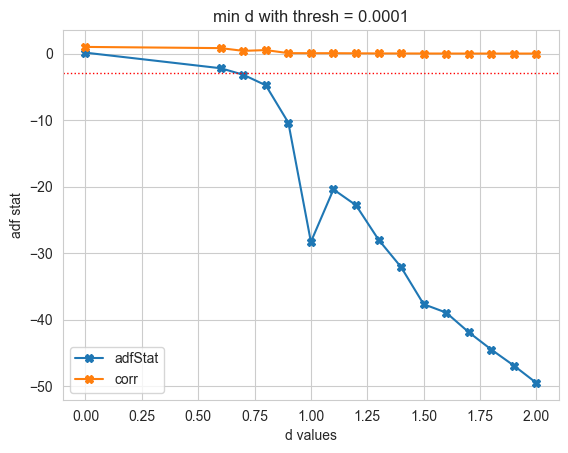

In [43]:
f,ax = plt.subplots()
out[['adfStat', 'corr']].plot(ax = ax, marker = 'X')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = 'dotted')
ax.set_title('min d with thresh = 0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat')
display(out)

In [44]:
min_ffd = out[out.pVal <= 0.05].iloc[0].name
print("The min. D that makes the fracdiff stationary", min_ffd.round(1))

The min. D that makes the fracdiff stationary 0.7


In [45]:
dfx2 = fml.fracDiff_FFD(dollar_df, min_ffd, thres = 1e-5)
dfx2

,price,buy,sell,volume,v,dv
2020-01-09 09:33:05.216870,1.452653,-14.271878,41.533105,27.261227,27.261227,8.022040e+03
2020-01-09 09:40:19.264128,1.749530,-11.360756,-61.658864,-73.019620,-73.019620,-2.138765e+04
2020-01-09 09:44:59.525297,1.816882,-11.605438,-10.247763,-21.853201,-21.853201,-6.382174e+03
2020-01-09 09:50:06.666000,1.404480,40.144861,-7.703151,32.441709,32.441709,9.539509e+03
2020-01-09 09:59:00.000000,1.545416,2.148488,-4.325105,-2.176617,-2.176617,-6.178915e+02
...,...,...,...,...,...,...
2020-12-30 15:27:20.310469,2.176185,-10.880614,84.628108,73.747494,73.747494,2.877185e+04
2020-12-30 15:29:16.758887,1.837930,-3.805661,-0.559160,-4.364821,-4.364821,-1.723414e+03
2020-12-30 15:30:30.202459,2.098589,130.215084,-61.994567,68.220518,68.220518,2.657139e+04
2020-12-30 15:32:38.885000,2.122545,-95.405461,-11.938372,-107.343833,-107.343833,-4.180588e+04


CUSUM Filtering

In [46]:
threshold = dfx2.std().iat[0] * 2
tEvents = fml.getTEvents(dfx2.price, h = threshold)
tEvents

DatetimeIndex(['2020-01-10 11:36:00.618495', '2020-01-14 09:48:48.929533',
               '2020-01-15 10:02:32.211544', '2020-01-17 09:44:14.316750',
               '2020-01-20 09:43:14.803714', '2020-01-20 11:19:03.839616',
               '2020-01-21 10:11:58.565571', '2020-01-22 14:24:29.121175',
               '2020-01-23 09:46:36.518087', '2020-01-28 09:41:00.495818',
               ...
               '2020-12-28 15:33:48.808678', '2020-12-29 09:41:17.791324',
               '2020-12-29 12:32:19.743248', '2020-12-29 13:11:08.999100',
               '2020-12-29 13:51:40.386205', '2020-12-29 13:56:56.134737',
               '2020-12-30 09:42:16.632000', '2020-12-30 10:21:03.488023',
               '2020-12-30 10:31:57.522337', '2020-12-30 11:58:29.384816'],
              dtype='datetime64[ns]', length=1143, freq=None)

In [47]:
dollar_feature = dollar_df.price.loc[tEvents]
dollar_feature

2020-01-10 11:36:00.618495    295.05
2020-01-14 09:48:48.929533    303.70
2020-01-15 10:02:32.211544    300.00
2020-01-17 09:44:14.316750    305.15
2020-01-20 09:43:14.803714    305.95
                               ...  
2020-12-29 13:56:56.134737    378.05
2020-12-30 09:42:16.632000    380.95
2020-12-30 10:21:03.488023    380.35
2020-12-30 10:31:57.522337    381.20
2020-12-30 11:58:29.384816    384.95
Name: price, Length: 1143, dtype: float64

In [48]:
frac_diff_feature = dfx2.loc[tEvents]
frac_diff_feature

,price,buy,sell,volume,v,dv
2020-01-10 11:36:00.618495,1.032436,-39.606688,41.501982,1.895294,1.895294,543.125821
2020-01-14 09:48:48.929533,2.194487,-86.356992,-9.091595,-95.448586,-95.448586,-28902.295791
2020-01-15 10:02:32.211544,1.791590,-79.461136,46.553467,-32.907669,-32.907669,-9858.804049
2020-01-17 09:44:14.316750,1.612268,-24.225321,-4.238501,-28.463822,-28.463822,-8649.770670
2020-01-20 09:43:14.803714,1.718007,-21.414928,-37.374088,-58.789016,-58.789016,-17941.126592
...,...,...,...,...,...,...
2020-12-29 13:56:56.134737,2.308008,-2.978881,-32.441284,-35.420165,-35.420165,-13371.162625
2020-12-30 09:42:16.632000,2.019787,-28.612481,-4.143015,-32.755497,-32.755497,-12478.012845
2020-12-30 10:21:03.488023,1.417918,-5.180933,40.718253,35.537320,35.537320,13514.455943
2020-12-30 10:31:57.522337,2.676054,-10.626243,-3.637101,-14.263343,-14.263343,-5424.554151


In [49]:
feature_Mat = (pd.DataFrame().assign(dollar = dollar_feature, frac_diff_dollar = frac_diff_feature.price).drop_duplicates().dropna())
feature_Mat

,dollar,frac_diff_dollar
2020-01-10 11:36:00.618495,295.05,1.032436
2020-01-14 09:48:48.929533,303.70,2.194487
2020-01-15 10:02:32.211544,300.00,1.791590
2020-01-17 09:44:14.316750,305.15,1.612268
2020-01-20 09:43:14.803714,305.95,1.718007
...,...,...
2020-12-29 13:56:56.134737,378.05,2.308008
2020-12-30 09:42:16.632000,380.95,2.019787
2020-12-30 10:21:03.488023,380.35,1.417918
2020-12-30 10:31:57.522337,381.20,2.676054


Volatility

In [50]:
dailyVol = fml.getDailyVolatility(feature_Mat.dollar, span = 50)
dailyVol

2020-01-14 09:48:48.929533         NaN
2020-01-15 10:02:32.211544    0.029345
2020-01-17 09:44:14.316750    0.021203
2020-01-20 09:43:14.803714    0.017697
2020-01-20 11:19:03.839616    0.015176
                                ...   
2020-12-29 13:56:56.134737    0.011704
2020-12-30 09:42:16.632000    0.011498
2020-12-30 10:21:03.488023    0.011319
2020-12-30 10:31:57.522337    0.011109
2020-12-30 11:58:29.384816    0.010977
Name: dailyVol, Length: 1142, dtype: float64

<Axes: >

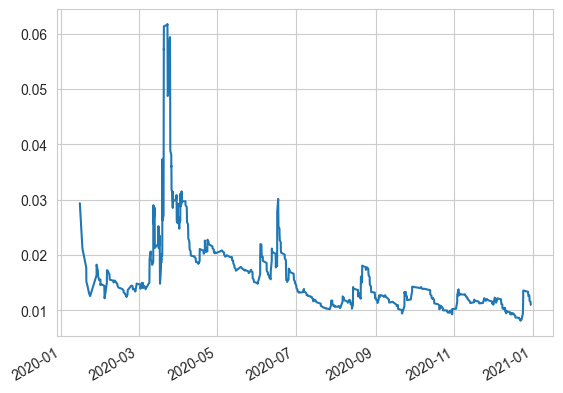

In [51]:
dailyVol.plot()

Vertical Barrier

In [52]:
t1 = fml.addVerticalBarrier(tEvents, feature_Mat.dollar, numDays = 1)
t1

2020-01-10 11:36:00.618495   2020-01-14 09:48:48.929533
2020-01-14 09:48:48.929533   2020-01-15 10:02:32.211544
2020-01-15 10:02:32.211544   2020-01-17 09:44:14.316750
2020-01-17 09:44:14.316750   2020-01-20 09:43:14.803714
2020-01-20 09:43:14.803714   2020-01-21 10:11:58.565571
                                        ...            
2020-12-28 09:41:35.259632   2020-12-29 12:32:19.743248
2020-12-28 10:29:57.385565   2020-12-29 12:32:19.743248
2020-12-28 14:47:35.435053   2020-12-30 09:42:16.632000
2020-12-28 15:33:48.808678   2020-12-30 09:42:16.632000
2020-12-29 09:41:17.791324   2020-12-30 09:42:16.632000
Length: 1135, dtype: datetime64[ns]

In [53]:
import platform
from multiprocessing import cpu_count
if platform.system() == 'Windows':
    cpus = 1
else:
    cpus = cpu_count() - 1
ptsl = [1,1]
target = dailyVol * 2
minRet = 0.001
cpus = cpu_count() - 1
events = fml.getEvents(feature_Mat.dollar, tEvents, ptsl, target, minRet, cpus, t1 = t1)

2023-06-23 01:36:41.960058 100.0% getTripleBarrier done after 0.09 minutes. Remaining 0.0 minutes..


In [54]:
events

,t1,trgt
2020-01-15 10:02:32.211544,2020-01-17 09:44:14.316750,0.058690
2020-01-17 09:44:14.316750,2020-01-20 09:43:14.803714,0.042407
2020-01-20 09:43:14.803714,2020-01-21 10:11:58.565571,0.035393
2020-01-20 11:19:03.839616,2020-01-22 14:24:29.121175,0.030352
2020-01-21 10:11:58.565571,2020-01-22 14:24:29.121175,0.028652
...,...,...
2020-12-29 13:56:56.134737,NaT,0.023408
2020-12-30 09:42:16.632000,NaT,0.022996
2020-12-30 10:21:03.488023,NaT,0.022638
2020-12-30 10:31:57.522337,NaT,0.022218


Concurrent Events

In [55]:
numCoEvents = fml.mpPandasObj(fml.getConcurrentBar, ('molecule', events.index), cpus, closeIdx = feature_Mat.index, t1 = events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep = 'last')]
numCoEvents = numCoEvents.reindex(feature_Mat.index).fillna(0)
out = pd.DataFrame()
out['tW'] = fml.mpPandasObj(fml.getAvgLabelUniq, ('molecule', events.index), cpus, t1 = events['t1'], numCoEvents = numCoEvents)
out

2023-06-23 01:36:47.334505 100.0% getConcurrentBar done after 0.07 minutes. Remaining 0.0 minutes..
2023-06-23 01:36:52.404125 100.0% getAvgLabelUniq done after 0.06 minutes. Remaining 0.0 minutes..


,tW
2020-01-15 10:02:32.211544,0.750000
2020-01-17 09:44:14.316750,0.500000
2020-01-20 09:43:14.803714,0.444444
2020-01-20 11:19:03.839616,0.388889
2020-01-21 10:11:58.565571,0.333333
...,...
2020-12-29 13:56:56.134737,0.140476
2020-12-30 09:42:16.632000,0.139881
2020-12-30 10:21:03.488023,0.144841
2020-12-30 10:31:57.522337,0.133929


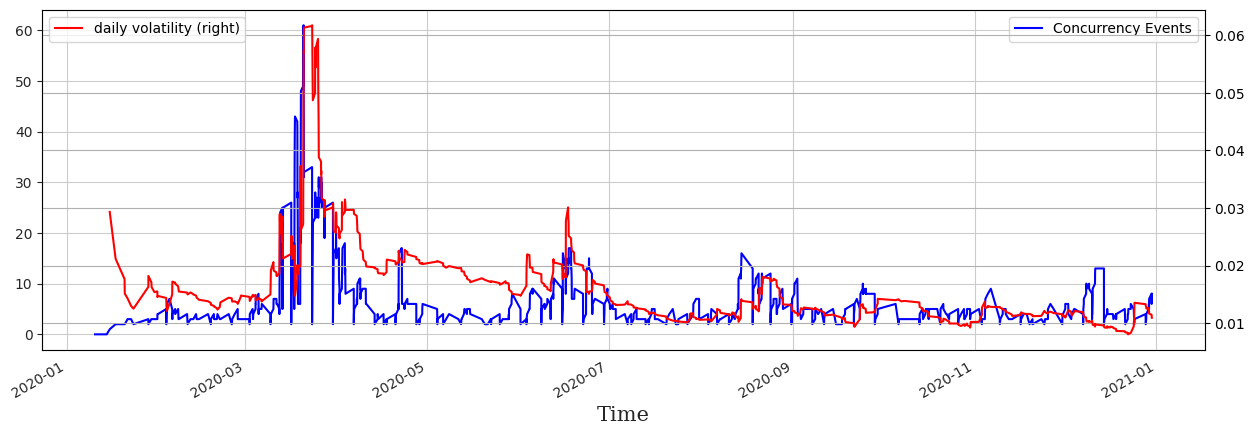

In [56]:
plt.figure(figsize = (15,5))
plt.xlabel('Time', fontfamily = 'Serif', fontsize = 15)

plt.style.use('default')
ax1 = numCoEvents.plot(color = 'blue', grid = True, label = 'Concurrency Events')
ax2 = dailyVol.plot(color = 'red', grid = True, secondary_y = True, label = 'daily volatility')

ax1.legend(loc = 1)
ax2.legend(loc = 2)

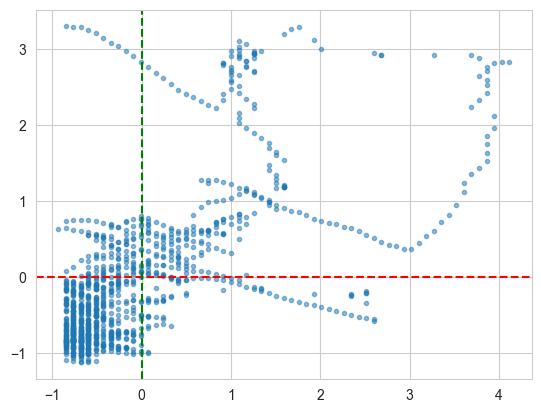

In [57]:
coEvents = numCoEvents.to_frame()
ewmasd = dailyVol.to_frame()
combine = ewmasd.join(coEvents, how = 'inner')
combine.columns = ['ewmasd', 'coEvents']
combine['ewmasd_std'] = (combine['ewmasd']-combine['ewmasd'].mean())/combine['ewmasd'].std()
combine['coEvents_std'] = (combine['coEvents']-combine['coEvents'].mean())/combine['coEvents'].std()

sns.set_style('whitegrid')
plt.scatter(combine['coEvents_std'], combine['ewmasd_std'], marker = '.', alpha = 0.5)
plt.axhline(y = combine['coEvents_std'].mean(), c='r', ls='--')
plt.axvline(x = combine['ewmasd_std'].mean(), c='g', ls='--')
plt.show()

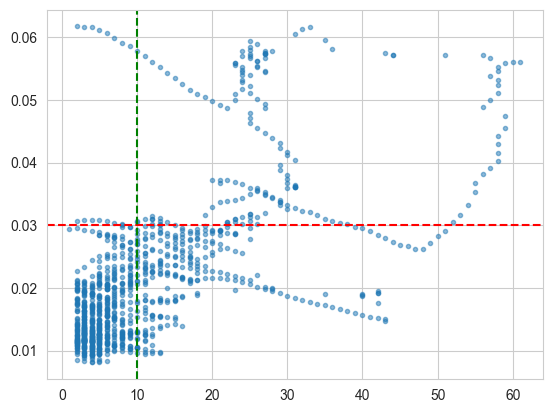

In [58]:
plt.scatter(combine['coEvents'], combine['ewmasd'], marker = '.', alpha = 0.5)
plt.axhline(y = 0.03, c='r', ls='--')
plt.axvline(x = 10, c='g', ls='--')
plt.show()

Weights

In [59]:
out['w'] = fml.mpPandasObj(fml.mpSampleW, ('molecule', events.index),
                           cpus, t1 = events['t1'], numCoEvents = numCoEvents, close = feature_Mat.dollar)
out['w'] *= out.shape[0] / out['w'].sum()
out

2023-06-23 01:36:58.707174 100.0% mpSampleW done after 0.07 minutes. Remaining 0.0 minutes..


,tW,w
2020-01-15 10:02:32.211544,0.750000,1.576161
2020-01-17 09:44:14.316750,0.500000,4.130134
2020-01-20 09:43:14.803714,0.444444,0.514623
2020-01-20 11:19:03.839616,0.388889,0.377037
2020-01-21 10:11:58.565571,0.333333,0.754074
...,...,...
2020-12-29 13:56:56.134737,0.140476,1.027546
2020-12-30 09:42:16.632000,0.139881,0.940068
2020-12-30 10:21:03.488023,0.144841,0.538306
2020-12-30 10:31:57.522337,0.133929,0.648801


1.0 0.0
-0.2752 0.0075
-1.1446 0.0127
-2.6068 0.0213
-3.4754 0.0264
-5.066 0.0358


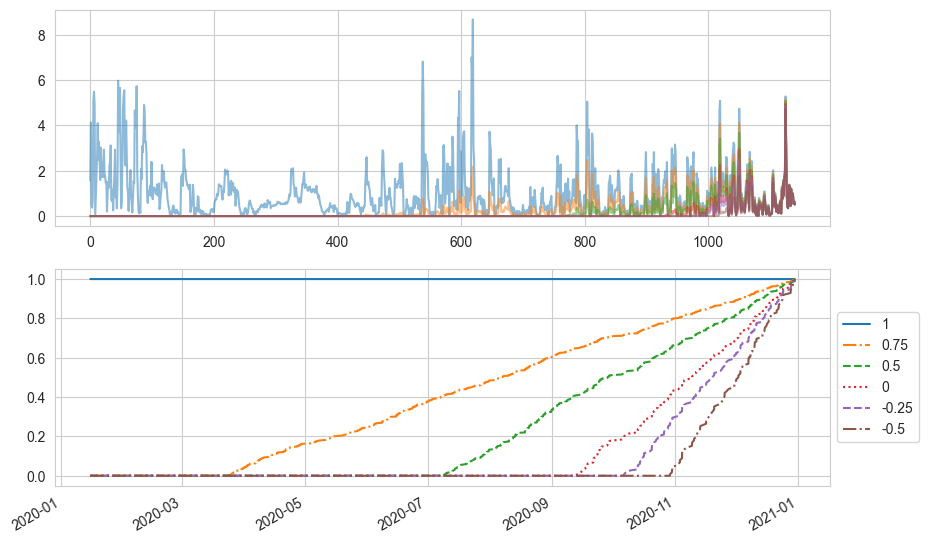

In [60]:
def getExTimeDecay(tW, clfLastW = 1.,exponent = 1):
    clfW = tW.sort_index().cumsum()
    if clfLastW >= 0: slope = ((1.-clfLastW)/clfW.iloc[-1]) ** exponent
    else: slope = (1./((clfLastW + 1) * clfW.iloc[-1])) ** exponent
    const = 1.-slope * clfW.iloc[-1]
    clfW = const + slope * clfW
    clfW[clfW < 0] = 0
    print(round(const, 4), round(slope, 4))
    return clfW

f,ax=plt.subplots(2,figsize=(10,7))
fs = [1,.75,.5,0,-.25,-.5]
ls = ['-','-.','--',':','--','-.']
for lstW, l in zip(fs,ls):
    decayFactor = getExTimeDecay(out['tW'].dropna(),
                                 clfLastW = lstW,
                                 exponent = 0.75) # experiment by changing exponent
    ((out['w'].dropna()*decayFactor).reset_index(drop=True)
     .plot(ax=ax[0],alpha=0.5))
    s = (pd.Series(1,index = out['w'].dropna().index) * decayFactor)
    s.plot(ax=ax[1], ls=l, label=str(lstW))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [61]:
s

2020-01-15 10:02:32.211544    0.000000
2020-01-17 09:44:14.316750    0.000000
2020-01-20 09:43:14.803714    0.000000
2020-01-20 11:19:03.839616    0.000000
2020-01-21 10:11:58.565571    0.000000
                                ...   
2020-12-29 13:56:56.134737    0.980514
2020-12-30 09:42:16.632000    0.985528
2020-12-30 10:21:03.488023    0.990719
2020-12-30 10:31:57.522337    0.995520
2020-12-30 11:58:29.384816    1.000000
Length: 1141, dtype: float64

In [62]:
feature_Mat = feature_Mat.join(out, how = 'left').join(target, how = 'left').dropna()
feature_Mat

,dollar,frac_diff_dollar,tW,w,dailyVol
2020-01-15 10:02:32.211544,300.00,1.791590,0.750000,1.576161,0.058690
2020-01-17 09:44:14.316750,305.15,1.612268,0.500000,4.130134,0.042407
2020-01-20 09:43:14.803714,305.95,1.718007,0.444444,0.514623,0.035393
2020-01-20 11:19:03.839616,307.60,2.333665,0.388889,0.377037,0.030352
2020-01-21 10:11:58.565571,305.05,1.049476,0.333333,0.754074,0.028652
...,...,...,...,...,...
2020-12-29 13:56:56.134737,378.05,2.308008,0.140476,1.027546,0.023408
2020-12-30 09:42:16.632000,380.95,2.019787,0.139881,0.940068,0.022996
2020-12-30 10:21:03.488023,380.35,1.417918,0.144841,0.538306,0.022638
2020-12-30 10:31:57.522337,381.20,2.676054,0.133929,0.648801,0.022218


In [63]:
# feature_Mat['w'] = feature_Mat['w'] * s

RSI

In [64]:
# Compute RSI
def calculate_rsi(prices, window):
    deltas = prices.diff()
    up = deltas.clip(lower=0)
    down = deltas.clip(upper=0).abs()

    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = calculate_rsi(df['dollar'], window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [65]:
data = feature_Mat.copy()
rsi_windows = [5, 13, 35]
for w in rsi_windows:
    rsi = get_rsi(data, window = w).squeeze()
    data[f'rsi_{w}'] = rsi

In [66]:
data

,dollar,frac_diff_dollar,tW,w,dailyVol,rsi_5,rsi_13,rsi_35
2020-01-15 10:02:32.211544,300.00,1.791590,0.750000,1.576161,0.058690,NaN,NaN,NaN
2020-01-17 09:44:14.316750,305.15,1.612268,0.500000,4.130134,0.042407,NaN,NaN,NaN
2020-01-20 09:43:14.803714,305.95,1.718007,0.444444,0.514623,0.035393,NaN,NaN,NaN
2020-01-20 11:19:03.839616,307.60,2.333665,0.388889,0.377037,0.030352,NaN,NaN,NaN
2020-01-21 10:11:58.565571,305.05,1.049476,0.333333,0.754074,0.028652,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-12-29 13:56:56.134737,378.05,2.308008,0.140476,1.027546,0.023408,59.756098,74.776119,59.101655
2020-12-30 09:42:16.632000,380.95,2.019787,0.139881,0.940068,0.022996,50.251256,79.290780,60.741301
2020-12-30 10:21:03.488023,380.35,1.417918,0.144841,0.538306,0.022638,78.125000,69.847328,60.466867
2020-12-30 10:31:57.522337,381.20,2.676054,0.133929,0.648801,0.022218,75.438596,66.094421,59.862385


autocorr

In [67]:
data['log_ret'] = np.log(data['dollar']).diff()

window_autocorr = 50
data['autocorr_1'] = (data['log_ret']
                          .rolling(window=window_autocorr,
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=1), raw=False))

data['autocorr_3'] = (data['log_ret']
                          .rolling(window=window_autocorr,
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=3), raw=False))

data['autocorr_5'] = (data['log_ret']
                          .rolling(window=window_autocorr,
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=5), raw=False))

In [68]:
data

,dollar,frac_diff_dollar,tW,w,dailyVol,rsi_5,rsi_13,rsi_35,log_ret,autocorr_1,autocorr_3,autocorr_5
2020-01-15 10:02:32.211544,300.00,1.791590,0.750000,1.576161,0.058690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-17 09:44:14.316750,305.15,1.612268,0.500000,4.130134,0.042407,NaN,NaN,NaN,0.017021,NaN,NaN,NaN
2020-01-20 09:43:14.803714,305.95,1.718007,0.444444,0.514623,0.035393,NaN,NaN,NaN,0.002618,NaN,NaN,NaN
2020-01-20 11:19:03.839616,307.60,2.333665,0.388889,0.377037,0.030352,NaN,NaN,NaN,0.005379,NaN,NaN,NaN
2020-01-21 10:11:58.565571,305.05,1.049476,0.333333,0.754074,0.028652,NaN,NaN,NaN,-0.008325,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-29 13:56:56.134737,378.05,2.308008,0.140476,1.027546,0.023408,59.756098,74.776119,59.101655,0.001456,-0.023827,-0.136490,0.042435
2020-12-30 09:42:16.632000,380.95,2.019787,0.139881,0.940068,0.022996,50.251256,79.290780,60.741301,0.007642,-0.018803,-0.124413,0.089173
2020-12-30 10:21:03.488023,380.35,1.417918,0.144841,0.538306,0.022638,78.125000,69.847328,60.466867,-0.001576,-0.010445,-0.126871,0.097719
2020-12-30 10:31:57.522337,381.20,2.676054,0.133929,0.648801,0.022218,75.438596,66.094421,59.862385,0.002232,-0.025887,-0.121406,0.065110


labeling

In [69]:
labels = fml.getBins(events, feature_Mat.dollar)
clean_labels = fml.dropLabels(labels, 0.05)
clean_labels

dropped label 0.0 0.00441306266548985


,ret,bin
2020-01-15 10:02:32.211544,0.017167,1.0
2020-01-17 09:44:14.316750,0.002622,1.0
2020-01-20 09:43:14.803714,-0.002942,-1.0
2020-01-20 11:19:03.839616,-0.005364,-1.0
2020-01-21 10:11:58.565571,0.002950,1.0
...,...,...
2020-12-28 09:41:35.259632,-0.000398,-1.0
2020-12-28 10:29:57.385565,0.002395,1.0
2020-12-28 14:47:35.435053,0.017087,1.0
2020-12-28 15:33:48.808678,0.014109,1.0


feature matrix

In [70]:
from multiprocessing import Pool
import test

if __name__ == "__main__":
    with Pool() as pool:
        seqUs = test.main_mp(t1)
        #result = pool.map(test.main_mp(t1), range(10))
        #print(result)

2023-06-23 01:37:14.066051 100.0% mp_func done after 0.2 minutes. Remaining 0.0 minutes.


In [71]:
avg_uniqueness = seqUs.mean()[0]
avgU1 = out['tW'].mean()

#### Primary Model

In [72]:
target = clean_labels.bin
target

2020-01-15 10:02:32.211544    1.0
2020-01-17 09:44:14.316750    1.0
2020-01-20 09:43:14.803714   -1.0
2020-01-20 11:19:03.839616   -1.0
2020-01-21 10:11:58.565571    1.0
                             ... 
2020-12-28 09:41:35.259632   -1.0
2020-12-28 10:29:57.385565    1.0
2020-12-28 14:47:35.435053    1.0
2020-12-28 15:33:48.808678    1.0
2020-12-29 09:41:17.791324    1.0
Name: bin, Length: 1128, dtype: float64

In [73]:
data = data.join(target, how = 'left').dropna()
data

,dollar,frac_diff_dollar,tW,w,dailyVol,rsi_5,rsi_13,rsi_35,log_ret,autocorr_1,autocorr_3,autocorr_5,bin
2020-02-25 10:55:13.739084,282.75,0.803669,0.320833,0.347855,0.028170,8.215297,21.508828,47.635605,0.005141,0.162134,0.176805,0.090253,-1.0
2020-02-25 13:28:46.795320,283.40,2.065609,0.261111,0.733383,0.027578,13.548387,22.503962,51.512915,0.002296,0.155676,0.173526,0.110586,-1.0
2020-02-26 09:42:23.223484,280.25,1.692568,0.261111,2.840046,0.027643,12.462908,12.380952,48.571429,-0.011177,0.139747,0.191227,0.161001,-1.0
2020-02-27 09:41:07.361227,280.65,1.521886,0.288889,4.785561,0.027168,26.455026,15.061296,46.980854,0.001426,0.143313,0.206451,0.131296,-1.0
2020-02-27 10:36:09.711822,277.10,0.823069,0.333333,5.345973,0.026768,27.173913,13.395639,44.803371,-0.012730,0.141436,0.166736,0.155909,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28 09:41:35.259632,376.90,1.948366,0.283333,0.419534,0.026665,93.521127,66.396104,59.471366,0.007457,0.084273,-0.118397,0.239063,-1.0
2020-12-28 10:29:57.385565,375.85,2.711431,0.290000,0.364545,0.026143,94.050992,65.440000,60.000000,-0.002790,0.065061,-0.135787,0.243938,1.0
2020-12-28 14:47:35.435053,374.55,1.285100,0.198065,0.908357,0.025639,74.731183,67.603306,58.608696,-0.003465,0.076025,-0.143816,0.125892,1.0
2020-12-28 15:33:48.808678,375.65,2.651531,0.178741,1.394126,0.025134,64.661654,66.891892,60.207612,0.002933,0.071364,-0.130079,0.135616,1.0


### Secondary Model
use Primary Model Prediction

In [74]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [75]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

#### RandomForest Classifier

In [76]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from scipy import interp

rf = RandomForestClassifier(n_estimators = 1000, criterion = "entropy", bootstrap = True,
                                n_jobs=1, random_state = 42, class_weight = 'balanced_subsample', oob_score = False)

cv_gen0 = KFold(n_splits = 5, shuffle = False)

score = fml.cvScore(rf, X_train, y_train, sample_weight = X_train['w'], scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0.1)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.634359
CV Variance: 0.000169


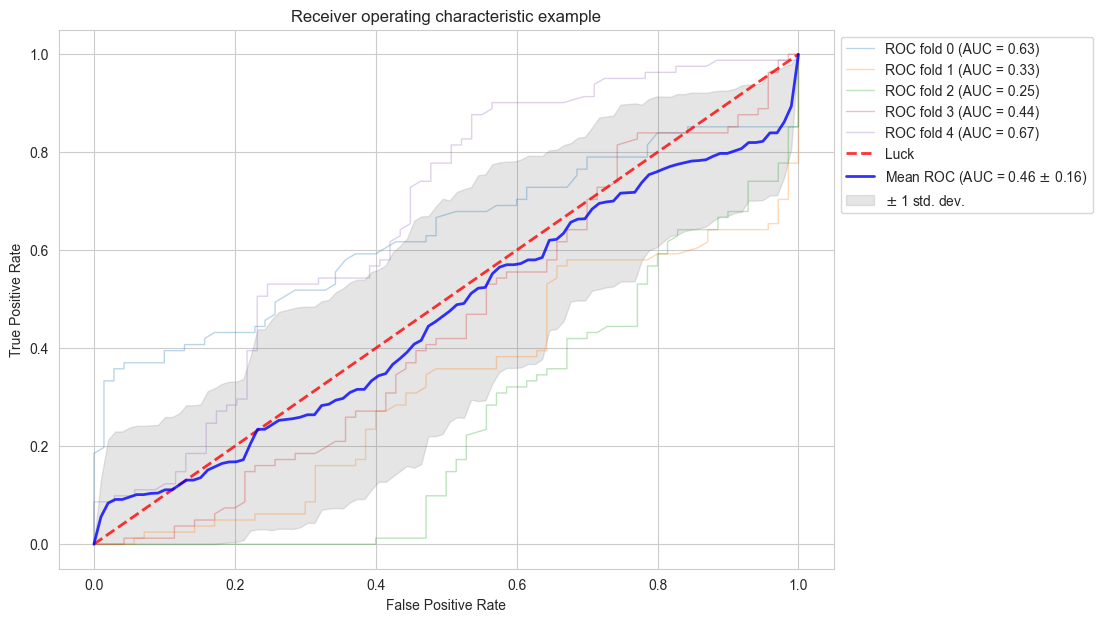

In [77]:
skf = StratifiedKFold(n_splits = 5, shuffle = False)
classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', bootstrap = True,
                                    class_weight = 'balanced_subsample', random_state = 42, oob_score = False)
fml.crossValPlot(skf, classifier, X_train, y_train)

              precision    recall  f1-score   support

    no trade       0.38      0.43      0.41       129
       trade       0.59      0.53      0.56       195

    accuracy                           0.49       324
   macro avg       0.48      0.48      0.48       324
weighted avg       0.51      0.49      0.50       324



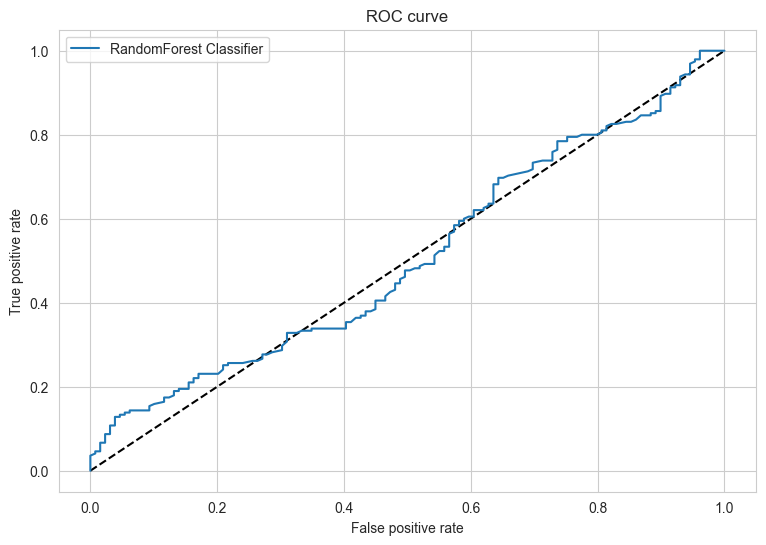

In [78]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

fit = rf.fit(X_train, y_train)

y_pred_rf = fit.predict_proba(X_test)[:, 1]
y_pred = fit.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'RandomForest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Feature Importance

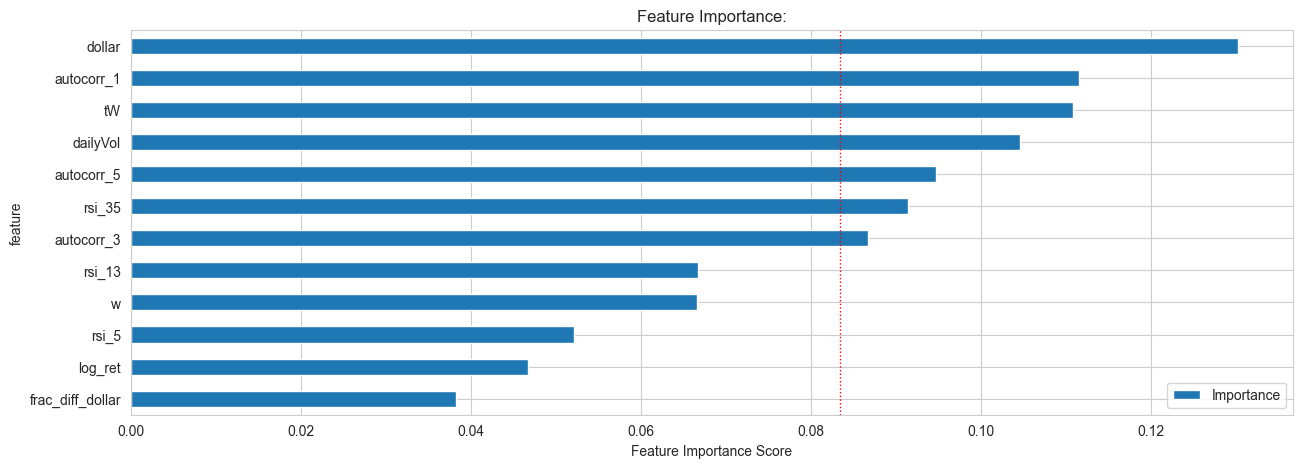

In [79]:
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.axvline(1. / feat_imp.shape[0], linewidth = 1, color='r', linestyle='dotted')
plt.xlabel('Feature Importance Score')
plt.show()

#### DecisionTree & Bagging Classifier

In [80]:
n_estimator = 1000
dt = DecisionTreeClassifier(criterion = 'entropy', max_features = 'auto', class_weight = 'balanced')
bc = BaggingClassifier(base_estimator = dt, n_estimators = n_estimator,
                       max_samples = avgU1, max_features = 1., random_state = 42)

In [81]:
cv_gen0 = KFold(n_splits = 5, shuffle = False)

score = fml.cvScore(bc, X_train, y_train, sample_weight = X_train['w'], scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0.1)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.645210
CV Variance: 0.000795


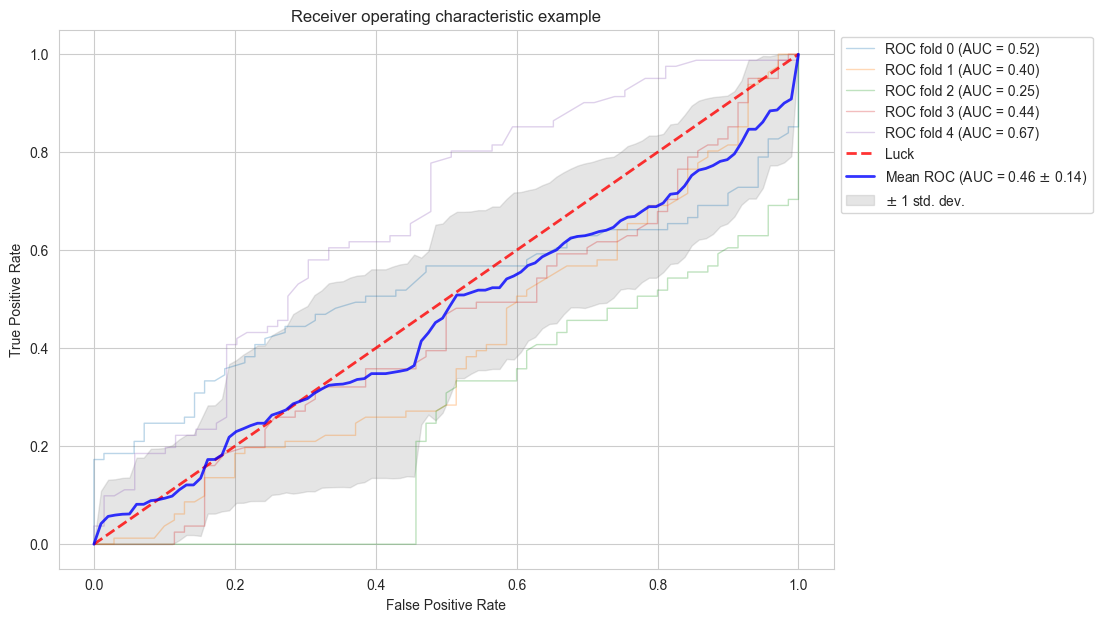

In [82]:
skf = StratifiedKFold(n_splits = 5, shuffle = False)
classifier = BaggingClassifier(base_estimator = dt, n_estimators = n_estimator,
                               max_samples = avgU1, max_features = 1., random_state = 42)
fml.crossValPlot(skf, classifier, X_train, y_train)

              precision    recall  f1-score   support

    no trade       0.38      0.43      0.41       129
       trade       0.59      0.53      0.56       195

    accuracy                           0.49       324
   macro avg       0.48      0.48      0.48       324
weighted avg       0.51      0.49      0.50       324



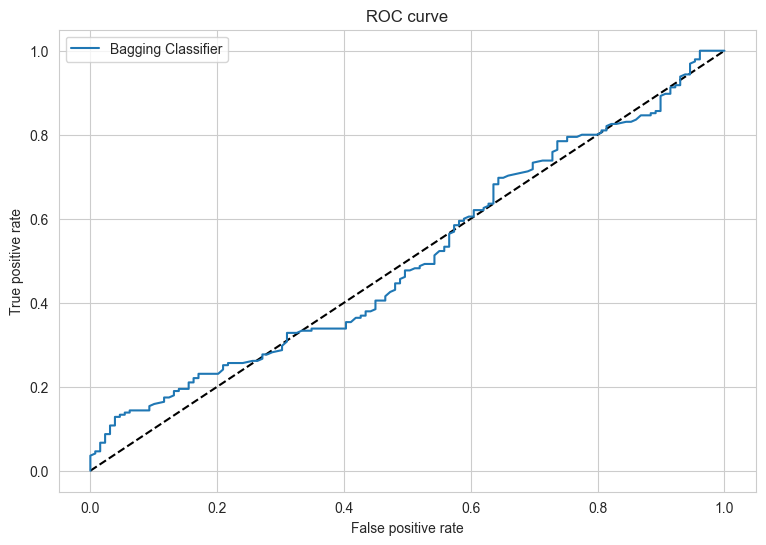

In [83]:
y_pred_bc = fit.predict_proba(X_test)[:, 1]
y_pred = fit.predict(X_test)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label = 'Bagging Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### RandomForest & Bagging Classifier

In [84]:
n_estimator = 1000
rf2 = RandomForestClassifier(n_estimators = 1, criterion = 'entropy', bootstrap = False, class_weight = 'balanced_subsample')
bc2 = BaggingClassifier(base_estimator = rf2, n_estimators = n_estimator,
                        max_samples = avgU1, max_features = 1., random_state = 42)

fit = bc2.fit(X_train, y_train)

In [85]:
cv_gen0 = KFold(n_splits = 5, shuffle = False)

score = fml.cvScore(bc2, X_train, y_train, sample_weight = X_train['w'], scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0.1)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.643399
CV Variance: 0.000441


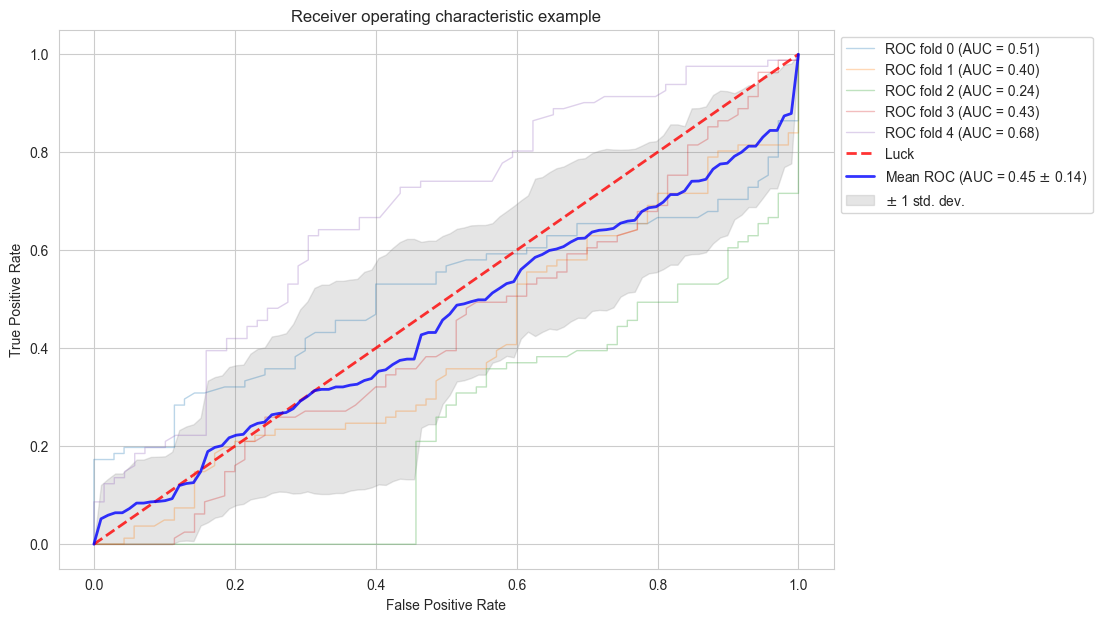

In [86]:
skf = StratifiedKFold(n_splits = 5, shuffle = False)
classifier = BaggingClassifier(base_estimator = rf2, n_estimators = n_estimator,
                               max_samples = avgU1, max_features = 1., random_state = 42)
fml.crossValPlot(skf, classifier, X_train, y_train)

              precision    recall  f1-score   support

    no trade       0.42      0.47      0.45       129
       trade       0.62      0.57      0.60       195

    accuracy                           0.53       324
   macro avg       0.52      0.52      0.52       324
weighted avg       0.54      0.53      0.54       324



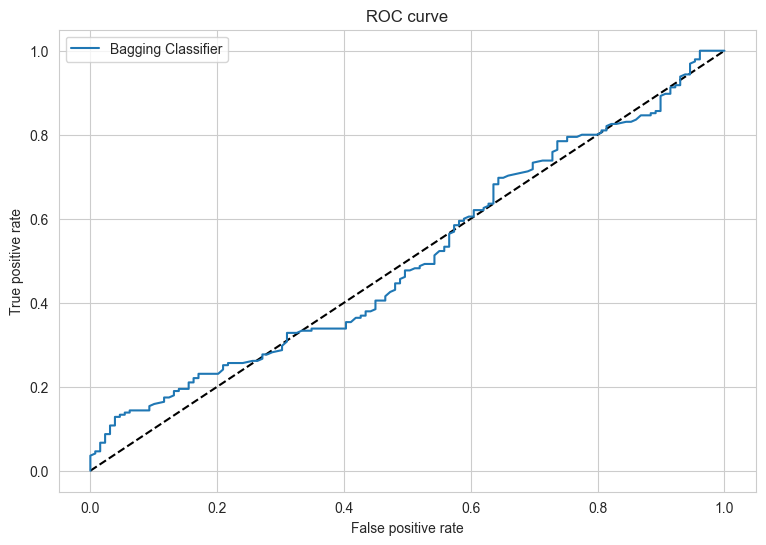

In [87]:
y_pred_bc2 = fit.predict_proba(X_test)[:, 1]
y_pred = fit.predict(X_test)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label = 'Bagging Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [97]:
yprf = pd.Series(y_pred_rf, index = X_test.index)
ytest = pd.Series(y_test, index = X_test.index)

In [98]:
yt = pd.DataFrame(yprf)
yt = pd.concat([yt, X_test['log_ret']], axis = 1)
yt = pd.concat([yt, ytest], axis = 1)
z = (yt[0] - 1 / 2) / (yt[0] * (1 - yt[0])) ** 0.5
cali_pred = (yprf - yprf.min()) / (yprf.max() - yprf.min())
yt = pd.concat([yt, z], axis = 1)
yt = pd.concat([yt, z * X_test['log_ret']], axis = 1)
yt = pd.concat([yt, cali_pred], axis = 1)
yt.columns = ['pred_prob','log_ret','bin','bet_size','profit','cali_pred']
print(yt)

                            pred_prob   log_ret  bin  bet_size        profit  \
2020-08-06 09:43:35.616491      0.591  0.029824  1.0  0.185091  5.520120e-03   
2020-08-06 10:53:57.250372      0.499  0.000161  1.0 -0.002000 -3.211052e-07   
2020-08-07 09:51:39.075039      0.416  0.004645  1.0 -0.170422 -7.915837e-04   
2020-08-07 11:13:37.393521      0.548 -0.004324  1.0  0.096445 -4.170120e-04   
2020-08-07 14:31:45.748849      0.539  0.001443  1.0  0.078238  1.129253e-04   
...                               ...       ...  ...       ...           ...   
2020-12-28 09:41:35.259632      0.427  0.007457 -1.0 -0.147581 -1.100479e-03   
2020-12-28 10:29:57.385565      0.487 -0.002790  1.0 -0.026009  7.255862e-05   
2020-12-28 14:47:35.435053      0.434 -0.003465  1.0 -0.133165  4.613939e-04   
2020-12-28 15:33:48.808678      0.439  0.002933  1.0 -0.122918 -3.604641e-04   
2020-12-29 09:41:17.791324      0.439  0.013879  1.0 -0.122918 -1.705983e-03   

                            cali_pred  

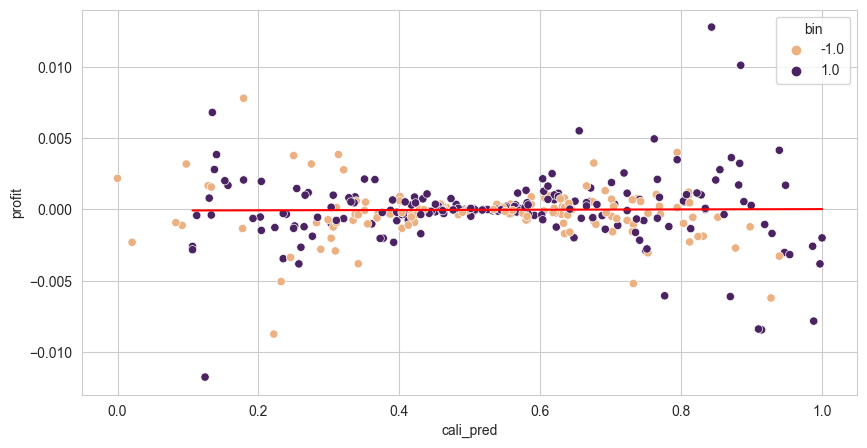

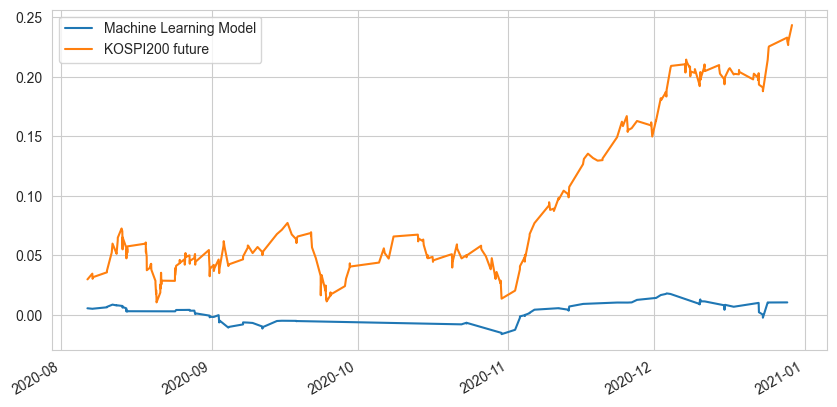

In [105]:
fig, ax = plt.subplots(figsize=(10, 5))

coefficients = np.polyfit(yt['cali_pred'][yt['bin'] == 1.0], yt['profit'][yt['bin'] == 1.0], 1)
regression_line = np.poly1d(coefficients)
x_range = np.linspace(np.min(yt['cali_pred'][yt['bin'] == 1.0]), np.max(yt['cali_pred'][yt['bin'] == 1.0]), 100)
y_range = regression_line(x_range)
ax.plot(x_range, y_range, color='red')

sns.scatterplot(data = yt, x = 'cali_pred', y="profit", hue='bin', palette='flare', ax=ax)
plt.show()

yt['profit'][yt['bin'] == 1][yt['cali_pred'] >= 0.5].cumsum().plot(label = 'Machine Learning Model', figsize = (10,5))
yt['log_ret'].cumsum().plot(label = 'KOSPI200 future')
plt.legend()

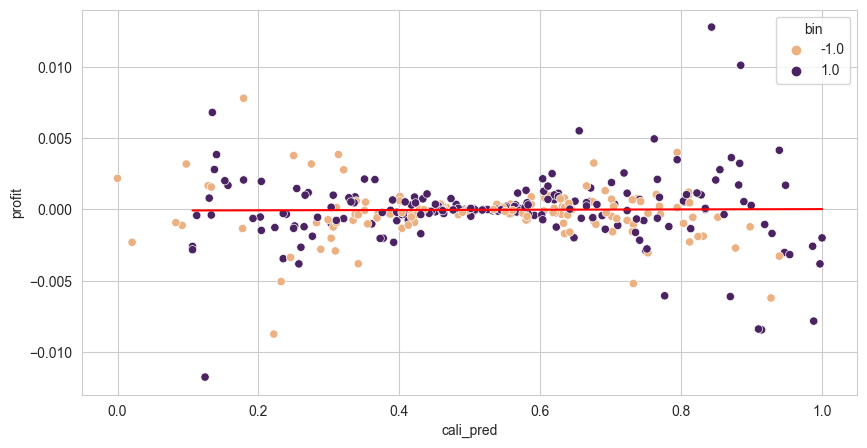

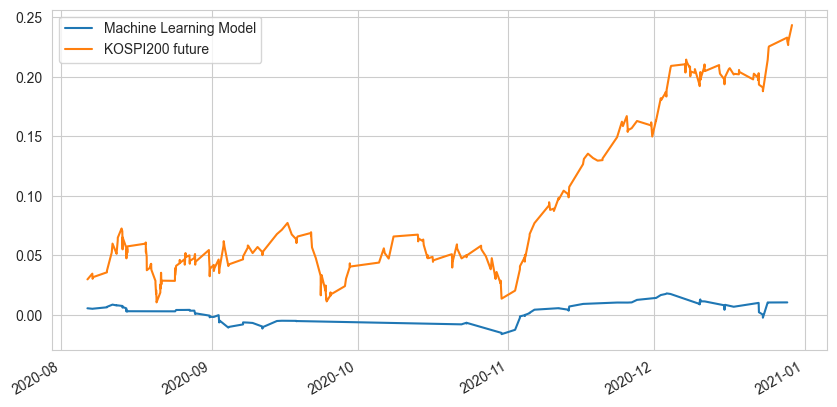

In [91]:
yprf = pd.Series(y_pred_bc, index = X_test.index)
ytest = pd.Series(y_test, index = X_test.index)
yt = pd.DataFrame(yprf)
yt = pd.concat([yt, X_test['log_ret']], axis = 1)
yt = pd.concat([yt, ytest], axis = 1)
z = (yt[0] - 1 / 2) / (yt[0] * (1 - yt[0])) ** 0.5
cali_pred = (yprf - yprf.min()) / (yprf.max() - yprf.min())
yt = pd.concat([yt, z], axis = 1)
yt = pd.concat([yt, z * X_test['log_ret']], axis = 1)
yt = pd.concat([yt, cali_pred], axis = 1)
yt.columns = ['pred_prob','log_ret','bin','bet_size','profit','cali_pred']

fig, ax = plt.subplots(figsize=(10, 5))

coefficients = np.polyfit(yt['cali_pred'][yt['bin'] == 1.0], yt['profit'][yt['bin'] == 1.0], 1)
regression_line = np.poly1d(coefficients)
x_range = np.linspace(np.min(yt['cali_pred'][yt['bin'] == 1.0]), np.max(yt['cali_pred'][yt['bin'] == 1.0]), 100)
y_range = regression_line(x_range)
ax.plot(x_range, y_range, color='red')

sns.scatterplot(data=yt, x='cali_pred', y="profit", hue='bin', palette='flare', ax=ax)
plt.show()

yt['profit'][yt['bin'] == 1][yt['cali_pred'] >= 0.5].cumsum().plot(label='Machine Learning Model', figsize=(10, 5))
yt['log_ret'].cumsum().plot(label='KOSPI200 future')
plt.legend()

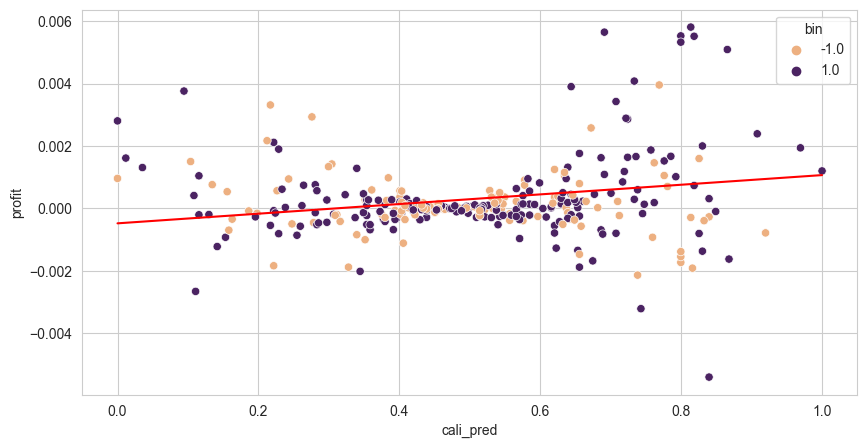

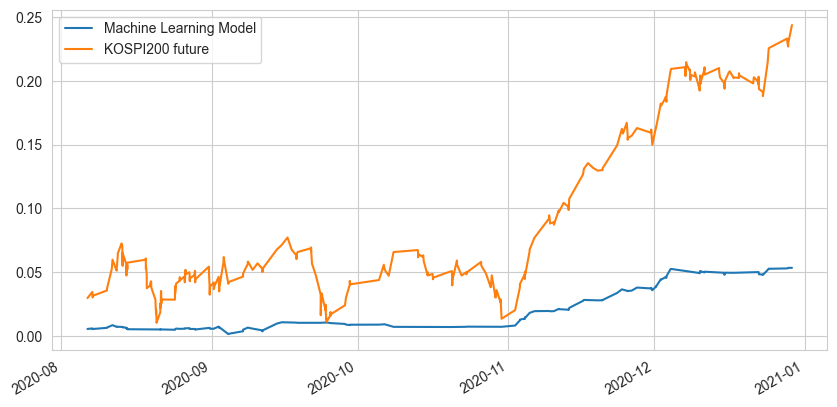

In [92]:
yprf = pd.Series(y_pred_bc2, index = X_test.index)
ytest = pd.Series(y_test, index = X_test.index)
yt = pd.DataFrame(yprf)
yt = pd.concat([yt, X_test['log_ret']], axis = 1)
yt = pd.concat([yt, ytest], axis = 1)
z = (yt[0] - 1 / 2) / (yt[0] * (1 - yt[0])) ** 0.5
cali_pred = (yprf - yprf.min()) / (yprf.max() - yprf.min())
yt = pd.concat([yt, z], axis = 1)
yt = pd.concat([yt, z * X_test['log_ret']], axis = 1)
yt = pd.concat([yt, cali_pred], axis = 1)
yt.columns = ['pred_prob','log_ret','bin','bet_size','profit','cali_pred']

fig, ax = plt.subplots(figsize=(10, 5))

coefficients = np.polyfit(yt['cali_pred'][yt['bin'] == 1.0], yt['profit'][yt['bin'] == 1.0], 1)
regression_line = np.poly1d(coefficients)
x_range = np.linspace(np.min(yt['cali_pred'][yt['bin'] == 1.0]), np.max(yt['cali_pred'][yt['bin'] == 1.0]), 100)
y_range = regression_line(x_range)
ax.plot(x_range, y_range, color='red')

sns.scatterplot(data=yt, x='cali_pred', y="profit", hue='bin', palette='flare', ax=ax)
plt.show()

yt['profit'][yt['bin'] == 1][yt['cali_pred'] >= 0.3].cumsum().plot(label='Machine Learning Model', figsize=(10, 5))
yt['log_ret'].cumsum().plot(label='KOSPI200 future')
plt.legend()